In [2]:
import numpy as np
from sklearn.datasets import load_iris, load_digits
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import umap
import requests
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(14,10)})

In [3]:
pd.set_option('display.max_colwidth', -1)
r = requests.get("https://api.opendota.com/api/leagues")
print(r.json()[:10])
leagues = pd.DataFrame(r.json())
leagues.sort_values("leagueid")

proleagues = leagues[leagues["name"].str.contains("DPC")]
NADPC = proleagues[proleagues["name"].str.contains("(NA)")]
print(NADPC[["leagueid","name"]])
SADPC = proleagues[proleagues["name"].str.contains("(SA)")]
print(SADPC[["leagueid","name"]])
SEADPC = proleagues[proleagues["name"].str.contains("(SEA)")]
print(SEADPC[["leagueid","name"]])
CNDPC = proleagues[proleagues["name"].str.contains("(CN)")]
print(CNDPC[["leagueid","name"]])
WEUDPC = proleagues[proleagues["name"].str.contains("(WEU)") | proleagues["name"].str.contains("Western Europe")]
print(WEUDPC[["leagueid","name"]])
EEUDPC = proleagues[proleagues["name"].str.contains("(EEU)") | proleagues["name"].str.contains("(CIS)") | proleagues["name"].str.contains("Eastern Europe")]
print(EEUDPC[["leagueid","name"]])


[{'leagueid': 1129, 'ticket': None, 'banner': None, 'tier': 'professional', 'name': 'Copa Argentina'}, {'leagueid': 1182, 'ticket': None, 'banner': None, 'tier': 'excluded', 'name': 'IGLStar Dota 2 Championship'}, {'leagueid': 2423, 'ticket': None, 'banner': None, 'tier': 'excluded', 'name': 'Miracle Tournament Season 1'}, {'leagueid': 2501, 'ticket': None, 'banner': None, 'tier': 'professional', 'name': 'Cup of Heroes 3'}, {'leagueid': 2535, 'ticket': None, 'banner': None, 'tier': 'professional', 'name': 'CI Cyber League: Second Cup'}, {'leagueid': 2556, 'ticket': None, 'banner': None, 'tier': 'excluded', 'name': 'Reverant Dota 2 Cup #1'}, {'leagueid': 2859, 'ticket': None, 'banner': None, 'tier': 'excluded', 'name': 'North American Solo Mid 1v1 Season 2'}, {'leagueid': 2896, 'ticket': None, 'banner': None, 'tier': 'excluded', 'name': 'Japan Dota Cup #4'}, {'leagueid': 2923, 'ticket': None, 'banner': None, 'tier': 'excluded', 'name': 'chuangleague'}, {'leagueid': 2969, 'ticket': None,

C:\Users\5cent\Anaconda3\lib\site-packages\pandas\core\strings.py:1843: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  return func(self, *args, **kwargs)


In [4]:
leagueids = {"NA Season 1":12735,"NA Season 2 Upper":13119,"NA Season 2 Lower":13120,
            "SA Season 1":12727,"SA Season 2 Upper":13109,"SA Season 2 Lower":13110,
            "SEA Season 1":12705,"SEA Season 2 Upper":13108,"SEA Season 2 Lower":13107,
            "CN Season 1":12723,"CN Season 2 Upper":13112,"CN Season 2 Lower":13113,
            "WEU Season 1":12720,"WEU Season 2 Upper":13114,"WEU Season 2 Lower":13115,
            "EEU Season 1":12718,"EEU Season 2 Upper":13116,"EEU Season 2 Lower":13117}

#SQL query for OpenDota explorer
"""
SELECT
matches.match_id,
matches.picks_bans,
matches.radiant_team_id,
matches.dire_team_id,
leagues.name leaguename,
team1.name AS radiant_team,
team2.name AS dire_team
FROM matches
JOIN leagues using(leagueid)
JOIN teams team1 ON matches.radiant_team_id = team1.team_id
JOIN teams team2 ON matches.dire_team_id = team2.team_id
WHERE leagueid = #####
"""

"https://www.opendota.com/explorer?sql=SELECT%0Amatches.match_id%2C%0Amatches.picks_bans%2C%0Amatches.radiant_team_id%2C%0Amatches.dire_team_id%2C%0Aleagues.name%20leaguename%2C%0Ateam1.name%20AS%20radiant_team%2C%0Ateam2.name%20AS%20dire_team%0AFROM%20matches%0AJOIN%20leagues%20using(leagueid)%0AJOIN%20teams%20team1%20ON%20matches.radiant_team_id%20%3D%20team1.team_id%0AJOIN%20teams%20team2%20ON%20matches.dire_team_id%20%3D%20team2.team_id%0AWHERE%20leagueid%20%3D%2012723&format="

In [5]:
#Encoding each pick or ban as a discrete column would be too sparse for the size of our dataset and would not represent 
#the relationship between each pick and ban, ie. picking a hero 1st and 2nd represents a more closely aligned preference
#than picking a hero 1st and 5th, or picking it 3rd and not picking it at all.
#So instead we will assign numerical values to each option, pick or ban to give each hero a value in each match for each team.

#first iteration
#first 4 bans = x + 1
#first 4 picks = x + 1
#next 6 bans = x/2 + 1
#next 4 picks = x/2 + 1
#last 4 bans = 1
#last 2 picks = 1

#we can approximate this with the function score = x - (x-1) * (i/23) where i is the pick/ban order.

In [6]:
import requests

#first we get the hero ids:
r = requests.get("https://api.opendota.com/api/heroes")

heroes = {}

for hero in r.json():
    i = hero["id"]
    name = hero["localized_name"]
    heroes[i] = name
    
print(heroes)

{1: 'Anti-Mage', 2: 'Axe', 3: 'Bane', 4: 'Bloodseeker', 5: 'Crystal Maiden', 6: 'Drow Ranger', 7: 'Earthshaker', 8: 'Juggernaut', 9: 'Mirana', 10: 'Morphling', 11: 'Shadow Fiend', 12: 'Phantom Lancer', 13: 'Puck', 14: 'Pudge', 15: 'Razor', 16: 'Sand King', 17: 'Storm Spirit', 18: 'Sven', 19: 'Tiny', 20: 'Vengeful Spirit', 21: 'Windranger', 22: 'Zeus', 23: 'Kunkka', 25: 'Lina', 26: 'Lion', 27: 'Shadow Shaman', 28: 'Slardar', 29: 'Tidehunter', 30: 'Witch Doctor', 31: 'Lich', 32: 'Riki', 33: 'Enigma', 34: 'Tinker', 35: 'Sniper', 36: 'Necrophos', 37: 'Warlock', 38: 'Beastmaster', 39: 'Queen of Pain', 40: 'Venomancer', 41: 'Faceless Void', 42: 'Wraith King', 43: 'Death Prophet', 44: 'Phantom Assassin', 45: 'Pugna', 46: 'Templar Assassin', 47: 'Viper', 48: 'Luna', 49: 'Dragon Knight', 50: 'Dazzle', 51: 'Clockwerk', 52: 'Leshrac', 53: "Nature's Prophet", 54: 'Lifestealer', 55: 'Dark Seer', 56: 'Clinkz', 57: 'Omniknight', 58: 'Enchantress', 59: 'Huskar', 60: 'Night Stalker', 61: 'Broodmother',

In [14]:
import requests
import time
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np

directory = "D:\\Stratz\\"

load_dict = {}

regions = ["NA","SA","SEA","CN","EEU","WEU"]
seasons = ["Season 1","Season 2 Upper","Season 2 Lower"]
pickscalingfactor = 1

for region in regions:
    for season in seasons:
        leagueid = leagueids[region + " " + season]
        r = requests.get("https://api.opendota.com/api/explorer?sql=SELECT%0Amatches.match_id%2C%0Amatches.picks_bans%2C%0Amatches.radiant_team_id%2C%0Amatches.dire_team_id%2C%0Aleagues.name%20leaguename%2C%0Ateam1.name%20AS%20radiant_team%2C%0Ateam2.name%20AS%20dire_team%0AFROM%20matches%0AJOIN%20leagues%20using(leagueid)%0AJOIN%20teams%20team1%20ON%20matches.radiant_team_id%20%3D%20team1.team_id%0AJOIN%20teams%20team2%20ON%20matches.dire_team_id%20%3D%20team2.team_id%0AWHERE%20leagueid%20%3D%20{0}&format=".format(leagueid))
        for match in r.json()["rows"]:
            pickbans = match["picks_bans"]
            if not pickbans:
                #this match was probably remade or for some other reason the draft phase wasn't recorded, for now we ignore.
                continue
            radiantteam = match["radiant_team"]
            direteam = match["dire_team"]
            radianttup = (region,radiantteam)
            diretup = (region,direteam)
            if radianttup not in load_dict:
                load_dict[radianttup] = dict(zip(heroes.keys(), [0]*len(heroes.keys())))
            if diretup not in load_dict:
                load_dict[diretup] = dict(zip(heroes.keys(), [0]*len(heroes.keys())))         
            for pickban in pickbans:
                heroid = pickban["hero_id"]
                team = pickban["team"]
                order = pickban["order"]
                score = pickscalingfactor - (pickscalingfactor-1)*(order/23)
                if team:
                    load_dict[diretup][heroid] += score
                else:
                    load_dict[radianttup][heroid] += score
        time.sleep(10)


In [15]:
df = pd.DataFrame.from_dict(load_dict,orient='index',columns=heroes.keys())
df.index.names = ['Region','Team']
print(df)

                           1    2    3    4    5    6    7     8     9   10  \
Region Team                                                                   
NA     Evil Geniuses     0.0  1.0  1.0  2.0  4.0  2.0  4.0  9.0   4.0   4.0   
       Quincy Crew       0.0  1.0  0.0  2.0  2.0  1.0  1.0  10.0  4.0   7.0   
       Arkosh Gaming     2.0  2.0  2.0  1.0  3.0  8.0  6.0  11.0  2.0   4.0   
       Simply TOOBASED   2.0  2.0  0.0  2.0  0.0  1.0  2.0  7.0   4.0   7.0   
       Undying           1.0  2.0  0.0  1.0  0.0  2.0  4.0  13.0  11.0  6.0   
...                      ...  ...  ...  ...  ...  ...  ...  ...   ...   ...   
WEU    burjui            2.0  1.0  0.0  0.0  0.0  0.0  1.0  1.0   0.0   2.0   
       Level UP          1.0  2.0  0.0  1.0  0.0  1.0  0.0  2.0   1.0   3.0   
       Team Bald Reborn  0.0  1.0  1.0  5.0  1.0  2.0  0.0  4.0   1.0   4.0   
       Into The Breach   2.0  7.0  0.0  0.0  0.0  0.0  0.0  2.0   2.0   5.0   
       Ghost Frogs       3.0  4.0  1.0  4.0  1.0  2.

In [16]:
print(df.xs("WEU", level="Region").sum(axis=1))
df = df.div(df.sum(axis=1), axis=0)
print(df.xs("NA", level="Region").sum(axis=1))

Team
Hippomaniacs         347.0
Meta4Pro             144.0
Brame                444.0
Spider Pigzs         204.0
Into the Breach      240.0
No Bounty Hunter     408.0
mudgolems            96.0 
OG                   504.0
Nigma                432.0
ViKin.gg             432.0
high coast           132.0
Tundra Esports       432.0
Alliance             456.0
Team Liquid          480.0
Team Secret          420.0
Hellbear Smashers    432.0
Chicken Fighters     216.0
burjui               132.0
Level UP             192.0
Team Bald Reborn     180.0
Into The Breach      144.0
Ghost Frogs          204.0
dtype: float64
Team
Evil Geniuses          1.0
Quincy Crew            1.0
Arkosh Gaming          1.0
Simply TOOBASED        1.0
Undying                1.0
A-Team                 1.0
sadboys                1.0
Black N Yellow         1.0
5ManMidas              1.0
Electronic Boys        1.0
Byzantine Raiders      1.0
The Cut                1.0
DogChamp               1.0
4 Zoomers              1.0
fel

In [17]:
import umap

reducer = umap.UMAP()
embedding = reducer.fit_transform(df)

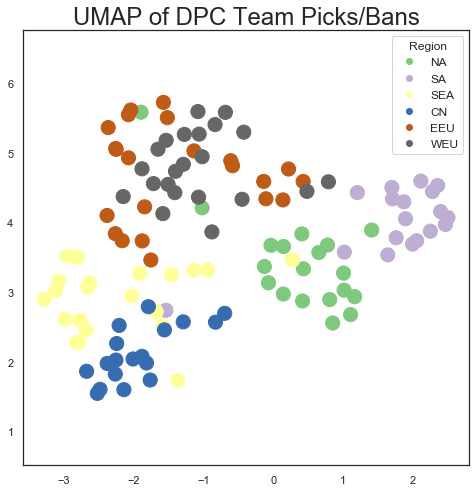

In [18]:
%matplotlib inline
sns.set(style='white', context='notebook', rc={'figure.figsize':(8,8)})

labelit = False

scatter = plt.scatter(embedding[:, 0], embedding[:, 1], c=[regions.index(x[0]) for x in df.index],cmap="Accent",s=200)
legend = plt.legend(scatter.legend_elements()[0],regions,loc="upper right",title="Region",fontsize=12)
plt.gca().set_aspect('equal', 'datalim')
plt.title('UMAP of DPC Team Picks/Bans', fontsize=24)
if labelit:
    for team,point in zip(df.index,embedding):
        label = team[1]
        plt.annotate(label, # this is the text
                     point, # this is the point to label
                     textcoords="offset points", # how to position the text
                     xytext=(0,0), # distance from text to points (x,y)
                     ha='center') # horizontal alignment can be left, right or center